## **Construction of machine learning (ML) models**

We will use Pycaret, a low-code, lighweight package to construct and compare ML models. The total dataset will be first divided into train_test and holdout data (80:20). The train_test set will be used to build and evaluate models. This holdout set will serve as unseen data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('data/01_mao_b_bioactivity_data_labelled.csv')  

# Stratified split to keep class distribution
train_test_df, holdout_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df['Class'],  # preserve class balance
    random_state=42        # for reproducibility
)

# Save or use these separately
print("Train+Test size:", train_test_df.shape)
print("Unseen size:", holdout_df.shape)

# Optional: Save to file
train_test_df.to_csv('data/train_test_set.csv', index=False)
holdout_df.to_csv('data/holdout_set.csv', index=False)

Train+Test size: (2781, 4)
Unseen size: (696, 4)


In [3]:
train_test_df.head()

,molecule_chembl_id,standardized_smiles,pIC50,Class
1897,CHEMBL350464,CC/N=C1/CCc2c1n(C)c1ccc(OC(=O)NC)cc21,3.000000,0
2105,CHEMBL1830834,O=C(NNc1ccc([N+](=O)[O-])cc1[N+](=O)[O-])c1cc2...,4.250882,0
2980,CHEMBL4450296,C#CCOc1ccc(-c2cc(-c3ccc(OCC#C)c(OC)c3)nc(C)n2)cc1,4.676129,0
1947,CHEMBL487050,COc1c(OCC(C)=O)ccc2c3c(c(=O)oc12)CCC3,4.886725,0
1804,CHEMBL5414652,Oc1cc(OCc2ccc(F)c(Cl)c2)ccc1CNc1ccccc1,7.481486,1


### **Calculation of MACCS fingerprints for train_test set**

In [4]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import pandas as pd

# Load DataFrame with SMILES data
data = pd.read_csv("data/train_test_set.csv")

# Convert SMILES to RDKit Mol objects
data['molecule'] = data['standardized_smiles'].apply(Chem.MolFromSmiles)

# Calculate MACCS fingerprints
fingerprints = []

for mol in data['molecule']:
    if mol is not None:
        fp = MACCSkeys.GenMACCSKeys(mol)
        fp_bits = list(fp.ToBitString())
        # Note: MACCSKey 0 is unused, so we remove the first bit
        fp_bits = fp_bits[1:]
    else:
        fp_bits = [None] * 166
    fingerprints.append(fp_bits)

# Convert to DataFrame
maccs_df = pd.DataFrame(fingerprints, columns=[f'MACCS_{i}' for i in range(1, 167)])

# Combine with original data
data = pd.concat([data, maccs_df], axis=1)

# Save to CSV
data.to_csv("data/03_mao_b_maccs_fingerprints.csv", index=False)

### **Feature selection**

In [5]:
descriptors = pd.read_csv("data/03_mao_b_maccs_fingerprints.csv")

In [6]:
descriptors.columns

Index(['molecule_chembl_id', 'standardized_smiles', 'pIC50', 'Class',
       'molecule', 'MACCS_1', 'MACCS_2', 'MACCS_3', 'MACCS_4', 'MACCS_5',
       ...
       'MACCS_157', 'MACCS_158', 'MACCS_159', 'MACCS_160', 'MACCS_161',
       'MACCS_162', 'MACCS_163', 'MACCS_164', 'MACCS_165', 'MACCS_166'],
      dtype='object', length=171)

In [7]:
columns_to_drop = ['molecule_chembl_id', 'standardized_smiles', 'pIC50', 'Class', 'molecule']

X = descriptors.drop(columns=columns_to_drop)
X.shape

(2781, 166)

In [8]:
y = descriptors['Class'] #class being predicted
y.shape

(2781,)

**Remove low variance fingerprints**

In [9]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)

# Fit the selector to your training data
selector.fit(X)

# Get the indices of the features to keep
indices_to_keep = selector.get_support(indices=True)

# Remove low variance features from data and transform back to DataFrame
X_filtered = pd.DataFrame(selector.transform(X),
                                     columns=X.columns[indices_to_keep])

In [10]:
X_filtered.shape

(2781, 133)

**Remove highly correlated descriptors**

In [11]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr().abs()

# Set the upper triangle of the correlation matrix to NaN
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than a threshold (e.g., 0.7)
high_corr_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

# Drop highly correlated columns
X_filtered_selected = X_filtered.drop(columns=high_corr_cols)

# Optionally, you can also drop the rows containing NaN values, if any
X_filtered_selected = X_filtered_selected.dropna()

In [12]:
X_filtered_selected.shape

(2781, 88)

In [13]:
X_filtered_selected.to_csv('data/04_mao_b_maccs_fp_selected.csv', index=False)
y.to_csv("data/labels.csv", index=False)

In [14]:
X = pd.read_csv("data/04_mao_b_maccs_fp_selected.csv")
y = pd.read_csv("data/labels.csv")['Class']

In [15]:
from pycaret.classification import *

# Combine X and y into a single DataFrame for PyCaret
df = X.copy()
df['target'] = y

In [16]:
clf_setup = setup(
    data=df,
    target='target',
    session_id=42,
    verbose=True,  # Set to True for debugging
    train_size=0.8,  # Explicit train-test split
    normalize=True,  # Only for numeric features (not SMILES)
    feature_selection=False,  # Disable PyCaret's default (use manual selection)
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=False,  # If dataset is imbalanced
    use_gpu=False  # Set to True if using GPU-accelerated models
)

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(2781, 89)"
4,Transformed data shape,"(2781, 89)"
5,Transformed train set shape,"(2224, 89)"
6,Transformed test set shape,"(557, 89)"
7,Numeric features,88
8,Preprocess,True
9,Imputation type,simple


In [17]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [18]:
best_model = compare_models(fold=10, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8633,0.9354,0.8669,0.8788,0.8726,0.7251,0.7256,0.1550
et,Extra Trees Classifier,0.8624,0.9268,0.8619,0.8817,0.8712,0.7236,0.7247,0.1370
xgboost,Extreme Gradient Boosting,0.8606,0.9327,0.8661,0.8758,0.8705,0.7196,0.7205,0.1170
lightgbm,Light Gradient Boosting Machine,0.8557,0.9280,0.8686,0.8662,0.8670,0.7092,0.7099,0.1220
knn,K Neighbors Classifier,0.8372,0.9069,0.8686,0.8369,0.8523,0.6711,0.6720,0.0560
qda,Quadratic Discriminant Analysis,0.8224,0.8907,0.8527,0.8257,0.8383,0.6413,0.6430,0.0460
dt,Decision Tree Classifier,0.8102,0.8152,0.8311,0.8203,0.8254,0.6176,0.6180,0.0500
gbc,Gradient Boosting Classifier,0.8089,0.8853,0.8569,0.8040,0.8292,0.6128,0.6151,0.1970
lr,Logistic Regression,0.7572,0.8231,0.8153,0.7564,0.7841,0.5075,0.5105,0.9490
ridge,Ridge Classifier,0.7567,0.0000,0.8245,0.7514,0.7856,0.5058,0.5099,0.0460


### **Random Forest model**

**model creation**

In [19]:
rf = create_model('rf', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8520,0.9405,0.8430,0.8793,0.8608,0.7030,0.7037
1,0.8655,0.9299,0.8678,0.8824,0.8750,0.7294,0.7295
2,0.8655,0.9178,0.9083,0.8516,0.8790,0.7279,0.7298
3,0.9103,0.9613,0.9167,0.9167,0.9167,0.8196,0.8196
4,0.8333,0.9248,0.8250,0.8609,0.8426,0.6657,0.6664
5,0.8514,0.9376,0.8667,0.8595,0.8631,0.7005,0.7005
6,0.8604,0.9334,0.8583,0.8803,0.8692,0.7195,0.7198
7,0.8468,0.9373,0.8500,0.8644,0.8571,0.6921,0.6922
8,0.8514,0.9295,0.8417,0.8783,0.8596,0.7018,0.7025


**Tune the hyperparameters**

In [20]:
rf = tune_model(rf, fold=10, n_iter=5, optimize='F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7399,0.7491,0.8678,0.7143,0.7836,0.4653,0.4793
1,0.6682,0.7351,0.8678,0.6442,0.7394,0.3091,0.3360
2,0.7175,0.7465,0.8917,0.6815,0.7726,0.4168,0.4437
3,0.7444,0.8233,0.8833,0.7114,0.7881,0.4753,0.4932
4,0.7117,0.8157,0.8917,0.6772,0.7698,0.4029,0.4309
5,0.6892,0.7888,0.9167,0.6509,0.7612,0.3509,0.3954
6,0.7207,0.7939,0.8833,0.6883,0.7737,0.4233,0.4462
7,0.6847,0.7677,0.9000,0.6506,0.7552,0.3430,0.3802
8,0.7252,0.8004,0.8917,0.6903,0.7782,0.4322,0.4571


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Display model**

In [21]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### **Extra Tree Classifier**

**model creation**

In [22]:
et = create_model('et', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8386,0.9396,0.8099,0.8829,0.8448,0.6773,0.6800
1,0.8655,0.9281,0.8843,0.8699,0.8770,0.7286,0.7287
2,0.8475,0.9042,0.9000,0.8308,0.8640,0.6912,0.6940
3,0.9103,0.9547,0.9250,0.9098,0.9174,0.8193,0.8195
4,0.8288,0.9086,0.8167,0.8596,0.8376,0.6569,0.6579
5,0.8423,0.9239,0.8417,0.8632,0.8523,0.6833,0.6835
6,0.8649,0.9309,0.8667,0.8814,0.8739,0.7283,0.7285
7,0.8694,0.9334,0.8583,0.8957,0.8766,0.7380,0.7387
8,0.8559,0.9137,0.8417,0.8860,0.8632,0.7111,0.7121


**tune the hyperparameters**

In [23]:
et = tune_model(et, fold=10, n_iter=5, optimize='F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7578,0.7493,0.8760,0.7310,0.7970,0.5030,0.5157
1,0.6592,0.7321,0.8512,0.6398,0.7305,0.2916,0.3142
2,0.7040,0.7493,0.8750,0.6731,0.7609,0.3895,0.4131
3,0.7399,0.8233,0.8750,0.7095,0.7836,0.4665,0.4828
4,0.7072,0.8101,0.8833,0.6752,0.7653,0.3941,0.4198
5,0.6892,0.7956,0.9167,0.6509,0.7612,0.3509,0.3954
6,0.7252,0.7955,0.9000,0.6879,0.7798,0.4313,0.4595
7,0.6892,0.7682,0.9000,0.6545,0.7579,0.3529,0.3892
8,0.7117,0.7779,0.8917,0.6772,0.7698,0.4029,0.4309


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Display the model**

In [24]:
et

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)

### **Extreme Gradient Boosting**

**model creation**

In [25]:
xgboost = create_model('xgboost', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8610,0.9474,0.8512,0.8879,0.8692,0.7210,0.7217
1,0.8744,0.9383,0.8760,0.8908,0.8833,0.7474,0.7476
2,0.8475,0.9169,0.9083,0.8258,0.8651,0.6907,0.6949
3,0.8789,0.9560,0.8667,0.9043,0.8851,0.7573,0.7580
4,0.8378,0.9204,0.8417,0.8559,0.8487,0.6740,0.6741
5,0.8514,0.9210,0.8667,0.8595,0.8631,0.7005,0.7005
6,0.8423,0.9216,0.8583,0.8512,0.8548,0.6824,0.6824
7,0.8423,0.9346,0.8250,0.8761,0.8498,0.6842,0.6856
8,0.8784,0.9434,0.9000,0.8780,0.8889,0.7546,0.7549


**tune the hyperparameters**

In [26]:
xgboost = tune_model(xgboost, fold=10, n_iter=5, optimize='F1', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8296,0.9362,0.9504,0.7823,0.8582,0.6497,0.6692
1,0.7892,0.9069,0.9091,0.7534,0.8240,0.5671,0.5827
2,0.8386,0.9087,0.9667,0.7838,0.8657,0.6689,0.6922
3,0.8430,0.9449,0.9500,0.7972,0.8669,0.6792,0.6948
4,0.8198,0.9100,0.9000,0.7941,0.8438,0.6329,0.6399
5,0.8018,0.9104,0.9667,0.7436,0.8406,0.5901,0.6264
6,0.8333,0.9276,0.9417,0.7902,0.8593,0.6587,0.6740
7,0.8288,0.8938,0.9417,0.7847,0.8561,0.6492,0.6657
8,0.8153,0.9394,0.9500,0.7651,0.8476,0.6201,0.6438


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Display the model**

In [27]:
xgboost

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

### Blending of models

In [28]:
# blend individual models based on soft labels i.e predicted probabilities
blend_soft = blend_models(estimator_list=[rf, et, xgboost,], method='soft', optimize='F1', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8610,0.9470,0.8347,0.9018,0.8670,0.7219,0.7242
1,0.8789,0.9370,0.8843,0.8917,0.8880,0.7563,0.7563
2,0.8610,0.9251,0.9250,0.8346,0.8775,0.7178,0.7229
3,0.9058,0.9595,0.9083,0.9160,0.9121,0.8107,0.8107
4,0.8243,0.9294,0.8167,0.8522,0.8340,0.6476,0.6483
5,0.8649,0.9360,0.8833,0.8689,0.8760,0.7275,0.7277
6,0.8559,0.9337,0.8750,0.8607,0.8678,0.7094,0.7095
7,0.8514,0.9404,0.8500,0.8718,0.8608,0.7014,0.7017
8,0.8829,0.9354,0.8750,0.9052,0.8898,0.7649,0.7654


In [29]:
# blend individual models based on hard labels i.e predicted probabilities
blend_soft = blend_models(estimator_list=[rf, et, xgboost,], method='hard', optimize='F1', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8520,0.0000,0.8264,0.8929,0.8584,0.7039,0.7062
1,0.8789,0.0000,0.8926,0.8852,0.8889,0.7559,0.7559
2,0.8565,0.0000,0.9083,0.8385,0.8720,0.7093,0.7123
3,0.9058,0.0000,0.9167,0.9091,0.9129,0.8104,0.8105
4,0.8288,0.0000,0.8167,0.8596,0.8376,0.6569,0.6579
5,0.8559,0.0000,0.8667,0.8667,0.8667,0.7098,0.7098
6,0.8694,0.0000,0.8667,0.8889,0.8776,0.7376,0.7379
7,0.8559,0.0000,0.8500,0.8793,0.8644,0.7107,0.7111
8,0.8559,0.0000,0.8500,0.8793,0.8644,0.7107,0.7111


Blending does not improve model efficacy

Finalize the model on entire dataset

In [30]:
final_rf = finalize_model(rf)

In [31]:
final_et = finalize_model(et)

In [32]:
final_xgboost = finalize_model(xgboost)

### **Now, we will invoke the holdout set as unseen data**

**Unseen data**

In [33]:
unseen_df = pd.read_csv("data/holdout_set.csv")

In [34]:
print(unseen_df.head())
print(unseen_df.shape)

  molecule_chembl_id                                standardized_smiles  \
0      CHEMBL3398528         COc1ccc(-c2c(Br)c3cc(C#N)c(C#N)cc3n2OC)cc1   
1       CHEMBL331245                         Cc1ccc2cc(O)c(C(=O)O)cc2c1   
2      CHEMBL4475910  CCc1c(O)c(=O)ccn1Cc1cc2ccc(OCc3cccc(Cl)c3)cc2o...   
3      CHEMBL4460336              O=C1Nc2ccc(OCc3ccc(Cl)c(Cl)c3)cc2C1=O   
4      CHEMBL1258499      O=C(c1ccccc1)c1nc2ccccc2n2c(-c3ccccc3Cl)nnc12   

      pIC50  Class  
0  4.000000      0  
1  7.720105      1  
2  6.372020      1  
3  8.522879      1  
4  3.420216      0  
(696, 4)


**Calculate MACCS fingerprints**

In [35]:
# Convert SMILES to RDKit Mol objects
unseen_df['molecule'] = unseen_df['standardized_smiles'].apply(Chem.MolFromSmiles)

# Calculate MACCS fingerprints
fingerprints = []

for mol in unseen_df['molecule']:
    if mol is not None:
        fp = MACCSkeys.GenMACCSKeys(mol)
        fp_bits = list(fp.ToBitString())
        # Note: MACCSKey 0 is unused, so we remove the first bit
        fp_bits = fp_bits[1:]
    else:
        fp_bits = [None] * 166
    fingerprints.append(fp_bits)

# Convert to DataFrame
maccs_df = pd.DataFrame(fingerprints, columns=[f'MACCS_{i}' for i in range(1, 167)])

In [36]:
maccs_df.shape

(696, 166)

In [37]:
# Combine with original data and the descriptors
unseen_df = pd.concat([unseen_df, maccs_df], axis=1)

In [38]:
unseen_df.to_csv("data/05_mao_b_maccs_fingerprints_unseen.csv", index=False)

In [39]:
descriptors = pd.read_csv("data/04_mao_b_maccs_fp_selected.csv")

In [40]:
descriptors.shape

(2781, 88)

In [41]:
unseen_df.shape

(696, 171)

**Extract the common descriptors between train_test set and unseen data**

In [42]:
common_features = descriptors.columns.intersection(unseen_df.columns)
common_features

Index(['MACCS_8', 'MACCS_17', 'MACCS_19', 'MACCS_22', 'MACCS_23', 'MACCS_24',
       'MACCS_25', 'MACCS_28', 'MACCS_32', 'MACCS_34', 'MACCS_36', 'MACCS_37',
       'MACCS_38', 'MACCS_41', 'MACCS_42', 'MACCS_43', 'MACCS_46', 'MACCS_50',
       'MACCS_52', 'MACCS_53', 'MACCS_54', 'MACCS_57', 'MACCS_59', 'MACCS_62',
       'MACCS_65', 'MACCS_66', 'MACCS_69', 'MACCS_72', 'MACCS_74', 'MACCS_75',
       'MACCS_77', 'MACCS_78', 'MACCS_79', 'MACCS_80', 'MACCS_82', 'MACCS_83',
       'MACCS_84', 'MACCS_85', 'MACCS_87', 'MACCS_89', 'MACCS_90', 'MACCS_91',
       'MACCS_92', 'MACCS_93', 'MACCS_95', 'MACCS_97', 'MACCS_98', 'MACCS_99',
       'MACCS_101', 'MACCS_103', 'MACCS_104', 'MACCS_106', 'MACCS_108',
       'MACCS_109', 'MACCS_111', 'MACCS_112', 'MACCS_113', 'MACCS_114',
       'MACCS_115', 'MACCS_116', 'MACCS_118', 'MACCS_120', 'MACCS_123',
       'MACCS_125', 'MACCS_126', 'MACCS_131', 'MACCS_132', 'MACCS_133',
       'MACCS_136', 'MACCS_137', 'MACCS_139', 'MACCS_140', 'MACCS_141',
       'M

In [43]:
subset = unseen_df[common_features]
subset

,MACCS_8,MACCS_17,MACCS_19,MACCS_22,MACCS_23,MACCS_24,MACCS_25,MACCS_28,MACCS_32,MACCS_34,...,MACCS_150,MACCS_151,MACCS_153,MACCS_154,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_164
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
692,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,1,1
693,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
694,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1


In [44]:
subset = subset.dropna()
subset

,MACCS_8,MACCS_17,MACCS_19,MACCS_22,MACCS_23,MACCS_24,MACCS_25,MACCS_28,MACCS_32,MACCS_34,...,MACCS_150,MACCS_151,MACCS_153,MACCS_154,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_164
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
692,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,1,1
693,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
694,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1


**Rename the Class column**

In [45]:
subset['true_class'] = unseen_df['Class'].values

**Make predictions using final models**

In [46]:
from pycaret.classification import predict_model

# Predict with ExtraTrees
pred_et = predict_model(final_et, data=subset.drop(columns='true_class'))
subset['pred_et'] = pred_et['prediction_label']

# Predict with XGBoost
pred_xgb = predict_model(final_xgboost, data=subset.drop(columns='true_class'))
subset['pred_xgb'] = pred_xgb['prediction_label']

# Predict with RandomForest
pred_rf = predict_model(final_rf, data=subset.drop(columns='true_class'))
subset['pred_rf'] = pred_rf['prediction_label']

In [48]:
from sklearn.metrics import classification_report

print("RandomForest Report:")
print(classification_report(subset['true_class'], subset['pred_rf']))

print("ExtraTrees Report:")
print(classification_report(subset['true_class'], subset['pred_et']))

print("XGBoost Report:")
print(classification_report(subset['true_class'], subset['pred_xgb']))

RandomForest Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       320
           1       0.89      0.90      0.90       376

    accuracy                           0.89       696
   macro avg       0.89      0.89      0.89       696
weighted avg       0.89      0.89      0.89       696

ExtraTrees Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       320
           1       0.89      0.89      0.89       376

    accuracy                           0.88       696
   macro avg       0.88      0.88      0.88       696
weighted avg       0.88      0.88      0.88       696

XGBoost Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       320
           1       0.88      0.89      0.89       376

    accuracy                           0.88       696
   macro avg       0.88      0.88      0.88       696
weighted avg      

**Calculation of AUC values**

In [49]:
# Remove any label column from the feature names if it exists
features_rf = [f for f in final_rf.feature_names_in_ if f != 'target']
features_et = [f for f in final_et.feature_names_in_ if f != 'target']
features_xgb = [f for f in final_xgboost.feature_names_in_ if f != 'target']

# Subset the unseen data
X_unseen_rf = subset[features_rf]
X_unseen_et = subset[features_et]
X_unseen_xgb = subset[features_xgb]

# Predict probabilities for class 1
proba_rf = final_rf.predict_proba(X_unseen_rf)[:, 1]
proba_et = final_et.predict_proba(X_unseen_et)[:, 1]
proba_xgb = final_xgboost.predict_proba(X_unseen_xgb)[:, 1]

# Compute AUCs
from sklearn.metrics import roc_auc_score

y_true = subset['true_class']

auc_rf = roc_auc_score(y_true, proba_rf)
auc_et = roc_auc_score(y_true, proba_et)
auc_xgb = roc_auc_score(y_true, proba_xgb)

print(f"AUC - Random Forest:   {auc_rf:.4f}")
print(f"AUC - Extra Trees:     {auc_et:.4f}")
print(f"AUC - XGBoost:         {auc_xgb:.4f}")

AUC - Random Forest:   0.9520
AUC - Extra Trees:     0.9292
AUC - XGBoost:         0.9535


**Showing all the metrices together**

In [50]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

# Helper to compute metrics
def evaluate_model(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Kappa': cohen_kappa_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
    }

# Predictions
pred_rf = final_rf.predict(X_unseen_rf)
pred_et = final_et.predict(X_unseen_et)
pred_xgb = final_xgboost.predict(X_unseen_xgb)

# Gather results
results = [
    ['rf'] + list(evaluate_model(y_true, pred_rf, proba_rf).values()),
    ['et'] + list(evaluate_model(y_true, pred_et, proba_et).values()),
    ['xgboost'] + list(evaluate_model(y_true, pred_xgb, proba_xgb).values()),
]

# DataFrame
metrics_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'AUC', 'Recall', 'Precision', 'F1', 'Kappa', 'MCC'])
metrics_df = metrics_df.round(4)
print(metrics_df)

     Model  Accuracy     AUC  Recall  Precision      F1   Kappa     MCC
0       rf    0.8865  0.9520  0.8989     0.8918  0.8954  0.7713  0.7714
1       et    0.8793  0.9292  0.8856     0.8904  0.8880  0.7572  0.7572
2  xgboost    0.8764  0.9535  0.8910     0.8816  0.8862  0.7510  0.7511


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Prepare feature subsets
features_rf = [f for f in final_rf.feature_names_in_ if f != 'target']
features_et = [f for f in final_et.feature_names_in_ if f != 'target']
features_xgb = [f for f in final_xgboost.feature_names_in_ if f != 'target']

X_unseen_rf = subset[features_rf]
X_unseen_et = subset[features_et]
X_unseen_xgb = subset[features_xgb]

# Predict probabilities
proba_unseen_rf = final_rf.predict_proba(X_unseen_rf)[:, 1]
proba_unseen_et = final_et.predict_proba(X_unseen_et)[:, 1]
proba_unseen_xgb = final_xgboost.predict_proba(X_unseen_xgb)[:, 1]

# True labels
y_true = subset['true_class']

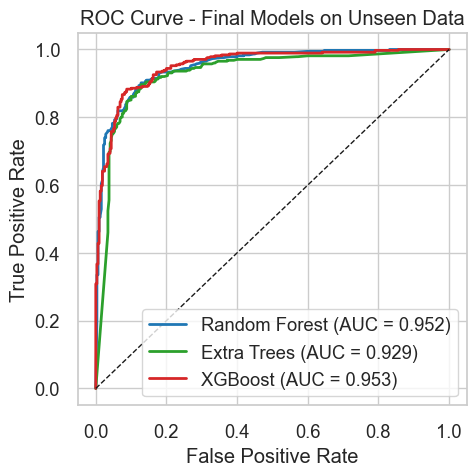

In [52]:
# Plot
plt.figure(figsize=(5, 5))

# Define model names and colors
model_names = ['Random Forest', 'Extra Trees', 'XGBoost']
probs = [proba_unseen_rf, proba_unseen_et, proba_unseen_xgb]
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

# Plot ROC curves
for name, prob, color in zip(model_names, probs, colors):
    fpr, tpr, _ = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2, color=color)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Models on Unseen Data')
plt.legend(loc='lower right', frameon=True)
plt.grid(True)

plt.tight_layout()
plt.savefig('plots/roc_auc.png', dpi=600, bbox_inches='tight')
plt.show()

**Confusion Matrices**

In [53]:
from pycaret.classification import predict_model
from sklearn.metrics import classification_report

# Work on a copy of the data
eval_df = subset.copy()
X_eval = eval_df.drop(columns='true_class')

# Dictionary of models: (non-finalized, finalized)
models = {
    'RandomForest': (rf, final_rf),
    'ExtraTrees': (et, final_et),
    'XGBoost': (xgboost, final_xgboost)
}

for name, (raw_model, final_model) in models.items():
    # Finalized model
    pred_final = predict_model(final_model, data=X_eval)
    pred_col_final = f'final_pred_{name.lower()}'
    eval_df[pred_col_final] = pred_final['prediction_label']

In [54]:
from sklearn.metrics import confusion_matrix

# Finalized model prediction columns
final_pred_cols = {
    'RandomForest': 'final_pred_randomforest',
    'ExtraTrees': 'final_pred_extratrees',
    'XGBoost': 'final_pred_xgboost'
}

# Compute and print confusion matrices
for model_name, pred_col in final_pred_cols.items():
    cm = confusion_matrix(eval_df['true_class'], eval_df[pred_col])
    print(f"\nConfusion Matrix for {model_name} (Final Model):")
    print(cm)


Confusion Matrix for RandomForest (Final Model):
[[279  41]
 [ 38 338]]

Confusion Matrix for ExtraTrees (Final Model):
[[279  41]
 [ 43 333]]

Confusion Matrix for XGBoost (Final Model):
[[275  45]
 [ 41 335]]


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model name and corresponding prediction column
final_pred_cols = {
    'RandomForest': 'final_pred_randomforest',
    'ExtraTrees': 'final_pred_extratrees',
    'XGBoost': 'final_pred_xgboost'
}

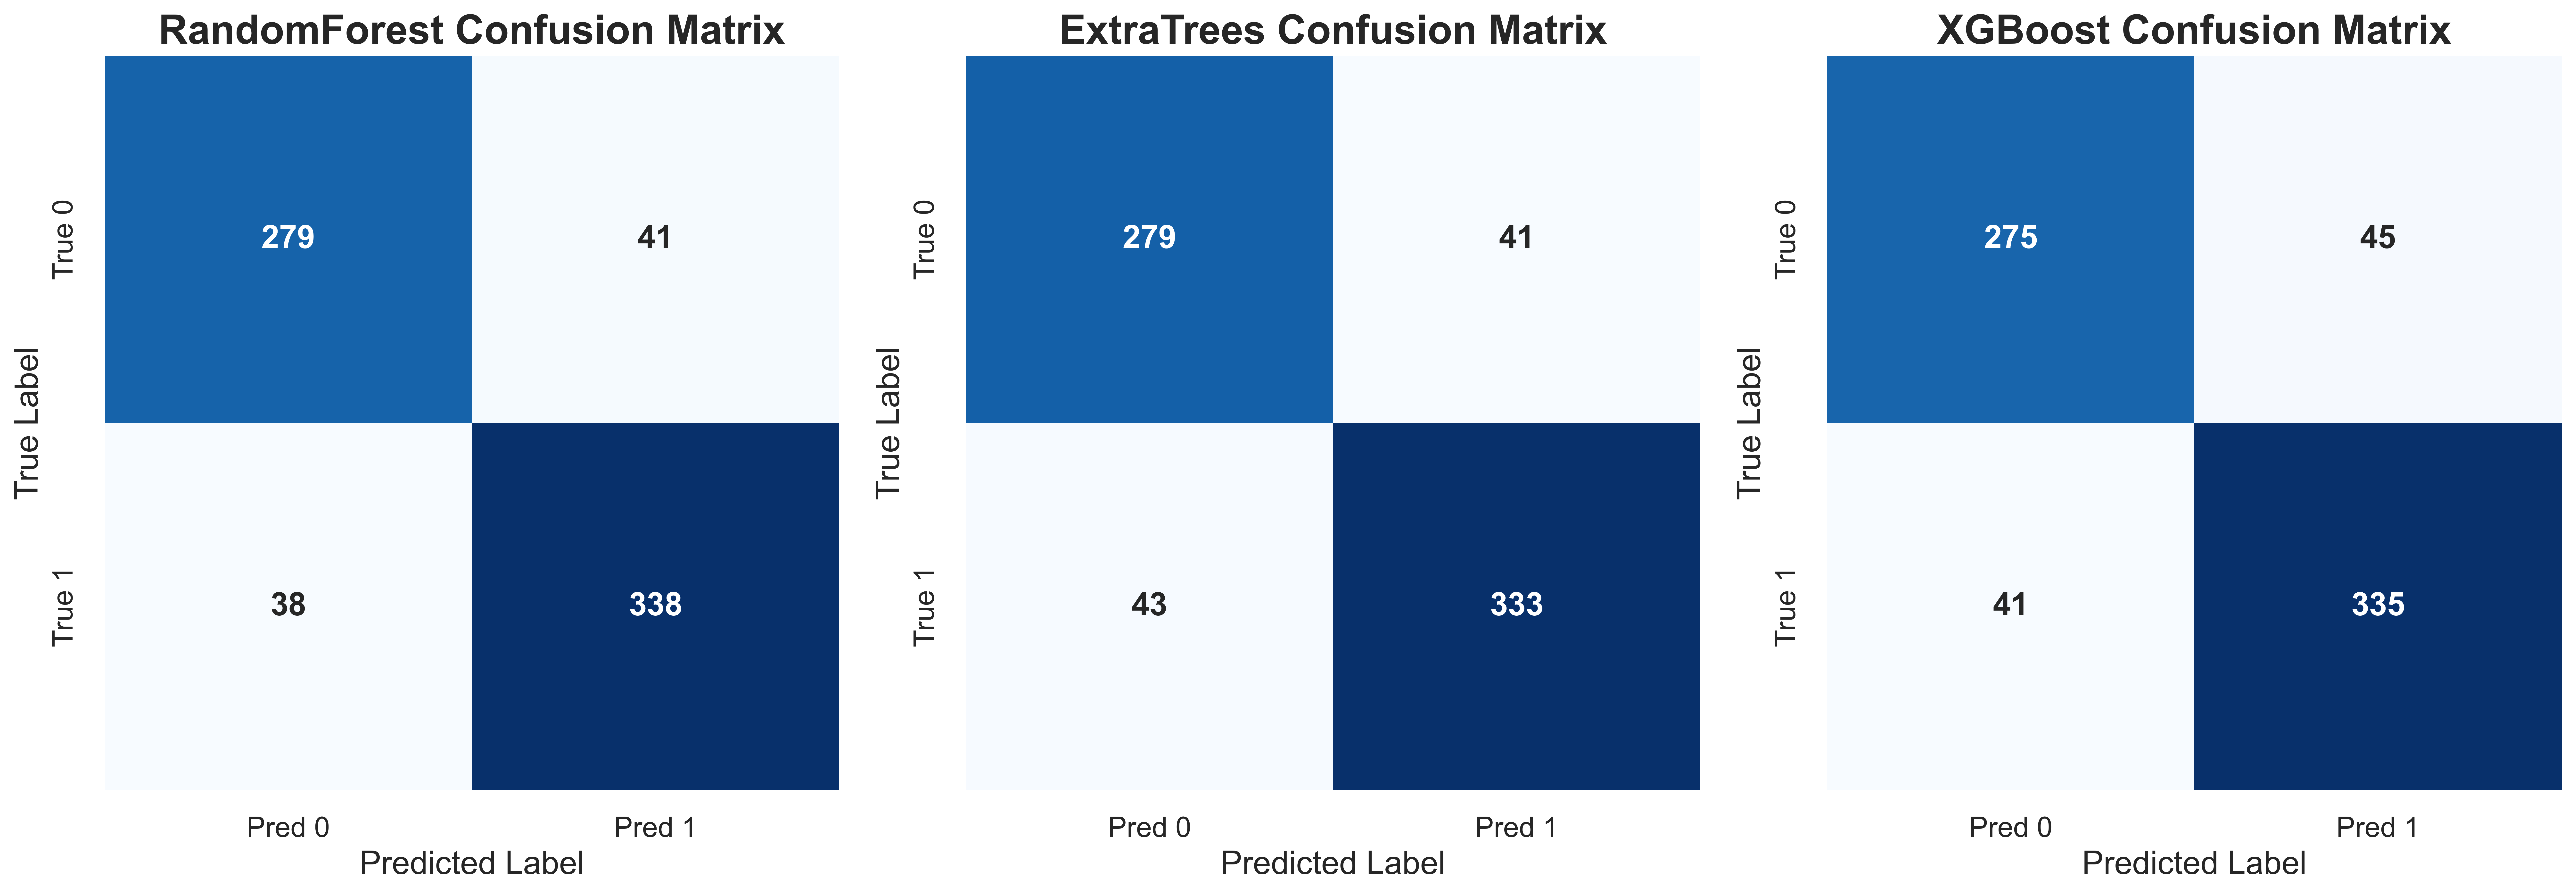

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Publication-style settings
sns.set(style='white', font_scale=1.4)  # Control font scale for all text

# Create 1x3 subplot with high DPI
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=600)

# Plot confusion matrices
for ax, (model_name, pred_col) in zip(axes, final_pred_cols.items()):
    cm = confusion_matrix(eval_df['true_class'], eval_df[pred_col])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, square=True,  # Square aspect
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'],
                annot_kws={"size": 16, "weight": "bold"})

    ax.set_title(f'{model_name} Confusion Matrix', fontsize=20, weight='bold')
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
# Optional: Save the figure
plt.savefig('plots/confusion_matrices.png', dpi=600, bbox_inches='tight')
plt.show()

**Top 15 features**

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names (excluding the target column)
feature_names = X.columns.tolist()

# Model name to finalized model mapping
final_models = {
    'RandomForest': final_rf,
    'ExtraTrees': final_et,
    'XGBoost': final_xgboost
}

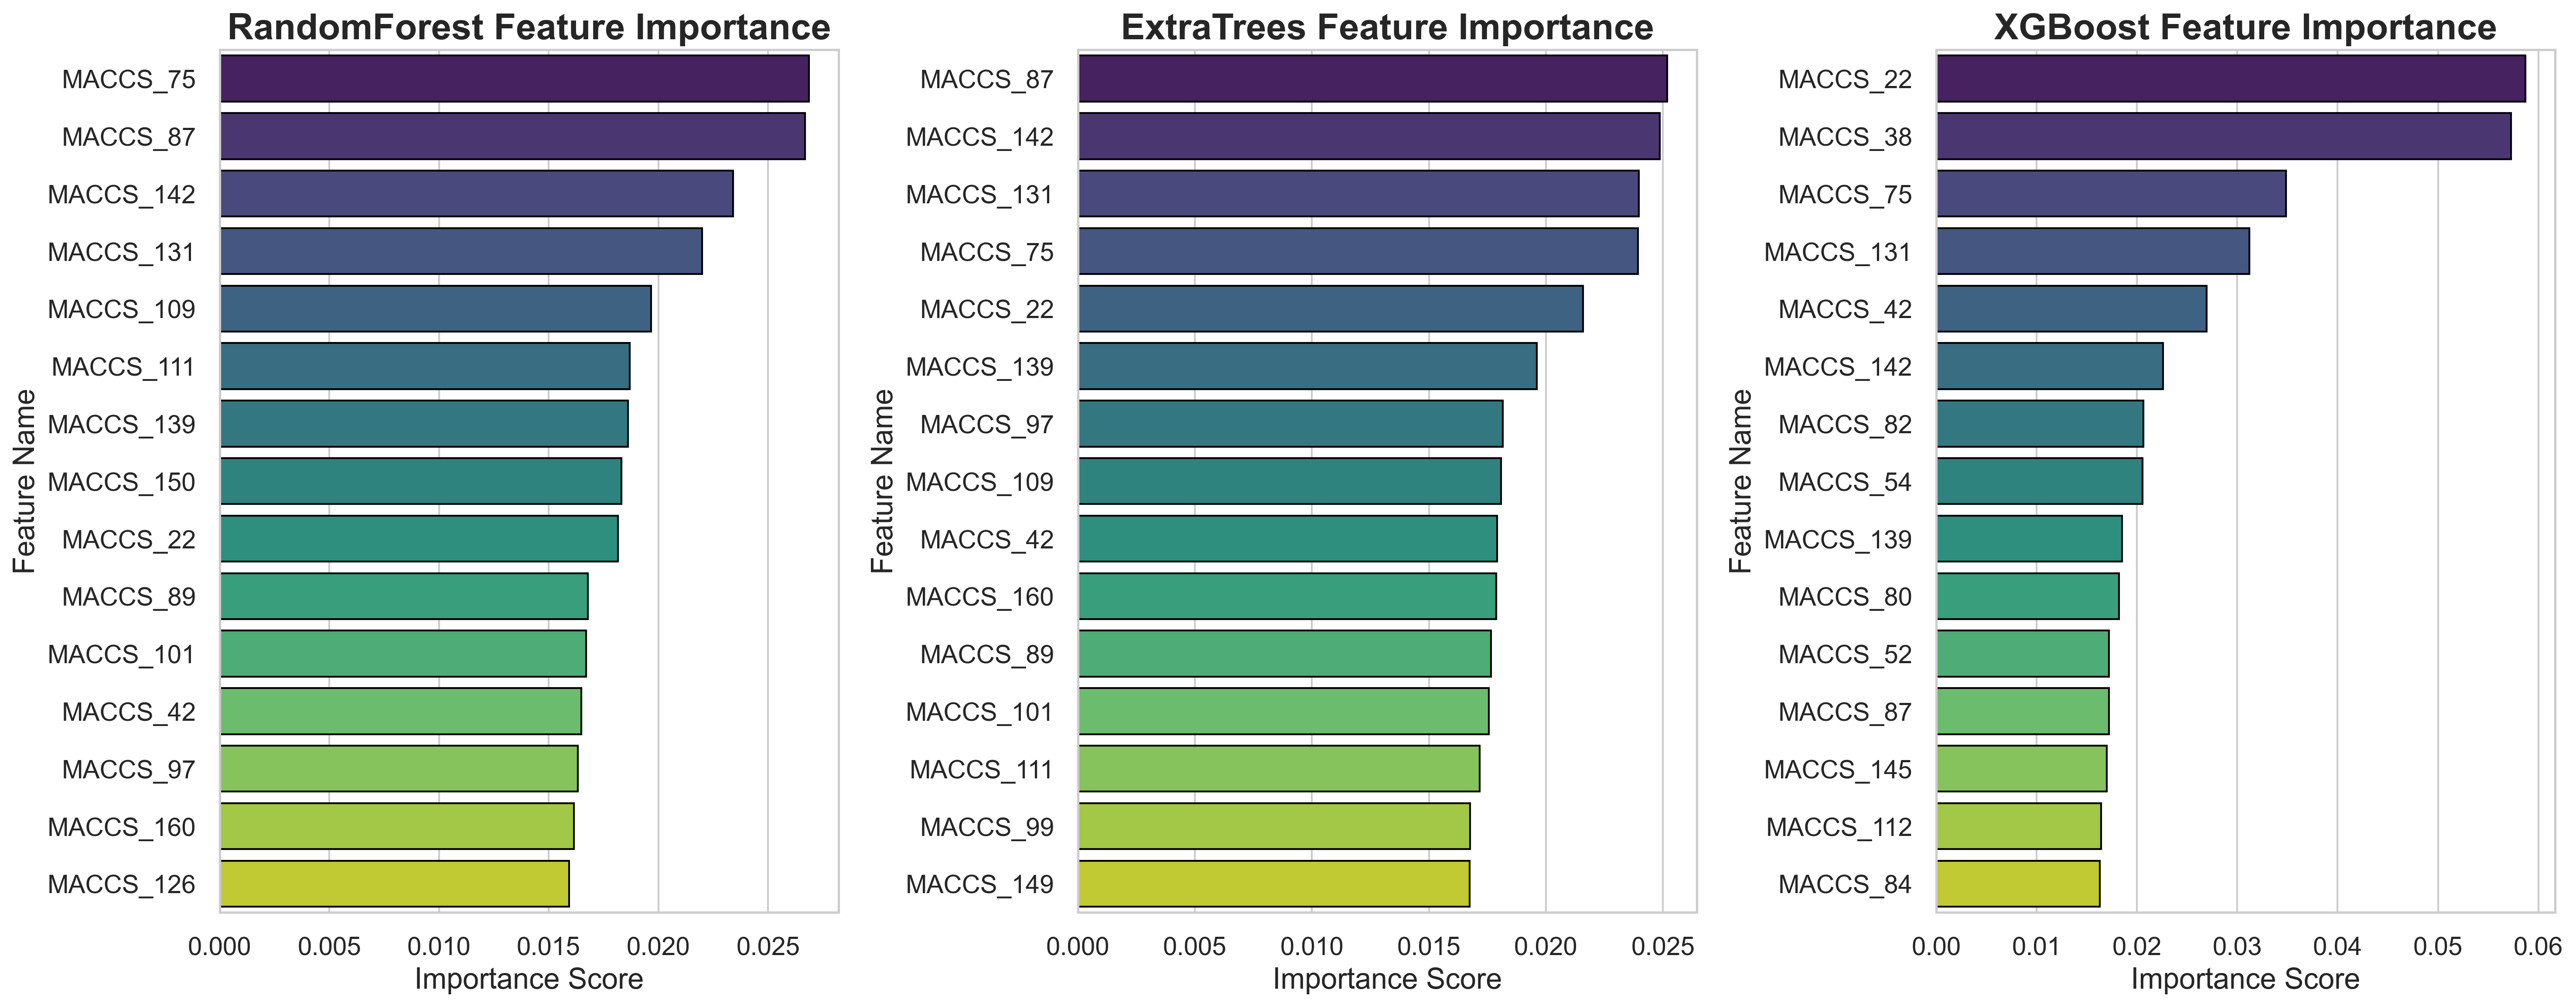

In [58]:
# Use publication-style seaborn theme
sns.set(style='whitegrid', font_scale=1.4)

# Plot top 15 features for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 8), dpi=300)

for ax, (model_name, model) in zip(axes, final_models.items()):
    # Extract feature importances
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15)

    # Plot
    sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax,
                palette='viridis', edgecolor='black')

    # Styling
    ax.set_title(f'{model_name} Feature Importance', fontsize=20, weight='bold')
    ax.set_xlabel('Importance Score', fontsize=16)
    ax.set_ylabel('Feature Name', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()

# Optional: Save as high-res image
plt.savefig("plots/feature_importance.png", dpi=600, bbox_inches='tight')

plt.show()

### **Save the models**

In [62]:
import joblib

joblib.dump(final_et, 'models/final_et_model.joblib')
joblib.dump(final_xgboost, 'models/final_xgboost_model.joblib')
joblib.dump(final_rf, 'models/final_rf_model.joblib')

print("All models saved successfully")

All models saved successfully
